# Checking P/S Ratio

In [2]:
# Code based on Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com, ai-investor.net
# Code uses bulk download data from the (presumably) nice people at https://simfin.com/.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from platform import python_version
print(python_version())

3.7.7


# 1. Get raw 'y' and 'x'

Where x is a DataFrame of the fundamental stock information to get P/S

And y is a DataFrame with data to get the stock return

In [2]:
# Get the daily share price data from SimFin.com bulk download
def getYRawData():
    d=pd.read_csv('us-shareprices-daily.csv', delimiter=';')
    d["Date"]=pd.to_datetime(d["Date"])
    print('Stock Price data matrix is: ',d.shape)
    return d

# Get the stock income statement data from SimFin.com bulk download
def getXData():
    a=pd.read_csv('us-income-annual.csv', delimiter=';')
    print('Income Statement CSV is: ', a.shape)
    a["Report Date"] = pd.to_datetime(a["Report Date"])
    a["Publish Date"] = pd.to_datetime(a["Publish Date"])
    return a


# Return just the price and volume near date (as have imperfect data).
# Want the volume data returned, to remove stocks with near 0 volume later.
# d is just the raw daily stock price data
# Modifier modifies the date to look between.
def getYPriceDataNearDate(ticker, date, modifier, d):
    windowDays=5
    rows = \
    d[(d["Date"].between(pd.to_datetime(date) + pd.Timedelta(days=modifier),\
       pd.to_datetime(date) + pd.Timedelta(days=windowDays+modifier))) \
      & (d["Ticker"]==ticker)]
    if rows.empty:
        return [ticker, np.float("NaN"),\
                np.datetime64('NaT'),\
                np.float("NaN")]
    else:
        return [ticker, rows.iloc[0]["Open"],\
                rows.iloc[0]["Date"],\
                rows.iloc[0]["Volume"]*rows.iloc[0]["Open"]]
        #take the first item of the list of days that fall in the window of accepted days.
        

        
# Modifier is effectively the hold period for a stock (here it is 1 year)
# x is the vector of company data
# d is the raw daily stock price data data (stock price and date for all days)
def getYPricesReportDateAndTargetDate(x, d, modifier=365):
    i=0
    # Preallocation list of list of 2 \
    # [(price at date) (price at date + modifier)]
    y = [[None]*8 for i in range(len(x))] 
    
    whichDateCol='Publish Date' # is the performance date from->to. Want this to be publish date.
    
    # Because of time lag between report date\
    # (which can't be actioned on) and publish date\
    # (data we can trade with)
    for index in range(len(x)):
        y[i]=(getYPriceDataNearDate(\
            x['Ticker'].iloc[index], x[whichDateCol].iloc[index], 0, d) + \
              getYPriceDataNearDate(\
            x['Ticker'].iloc[index], x[whichDateCol].iloc[index], modifier, d))
        i=i+1
    return y

In [4]:
x = getXData()

Income Statement CSV is:  (17202, 28)


In [6]:
# See the daily stock data
d = getYRawData()
d[d['Ticker']=='GOOG']

Stock Price data matrix is:  (5852233, 11)


,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
0,GOOG,18,2014-03-27,568.00,552.92,568.00,558.46,558.46,NaN,13100,336050831.0
1,GOOG,18,2014-03-28,561.20,558.67,566.43,559.99,559.99,NaN,41100,336050831.0
2,GOOG,18,2014-03-31,566.89,556.93,567.00,556.97,556.97,NaN,10800,674462000.0
3,GOOG,18,2014-04-01,558.71,558.71,568.45,567.16,567.16,NaN,7900,674462000.0
4,GOOG,18,2014-04-02,565.11,562.19,604.83,567.00,567.00,NaN,146700,674462000.0
...,...,...,...,...,...,...,...,...,...,...,...
1598,GOOG,18,2020-07-31,1505.01,1454.03,1508.95,1482.96,1482.96,NaN,3429036,680163635.0
1599,GOOG,18,2020-08-03,1486.64,1465.64,1490.47,1474.45,1474.45,NaN,2331514,680163635.0
1600,GOOG,18,2020-08-04,1476.57,1458.65,1485.56,1464.97,1464.97,NaN,1903489,680163635.0
1601,GOOG,18,2020-08-05,1469.30,1463.46,1482.41,1473.61,1473.61,NaN,1979957,680163635.0


In [7]:
# We want to know the performance for each stock, each year, between 10-K report dates.
# takes VERY long time, several hours.
y = getYPricesReportDateAndTargetDate(x, d, 365) # because of lookups in this function.

In [8]:
y= pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume', 'Ticker2', 'Open Price2', 'Date2', 'Volume2'])

y.to_csv("Annual_Stock_Price_Performance_.csv")
x.to_csv("Annual_Stock_Price_Fundamentals_.csv")

In [10]:
# Find out things about Y data
print("Y Shape:", y.shape)
print("X Shape:", x.shape)

Y Shape: (17202, 8)
X Shape: (17202, 28)


# 2. Filter down the data
Due to imperfect data and some stocks have low volume

In [7]:
x=pd.read_csv("Annual_Stock_Price_Fundamentals_.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_.csv", index_col=0)

In [14]:
# Issue where no share price
bool_list = ~y["Open Price"].isnull()
y=y[bool_list]
x=x[bool_list]

# Issues where no listed number of shares
bool_list = ~x["Shares (Diluted)"].isnull()
y=y[bool_list]
x=x[bool_list]

# Issue where there is low/no volume
bool_list =   ~((y['Volume']<1e4) | (y['Volume2']<1e4))
y=y[bool_list]
x=x[bool_list]

# Issue where dates missing (Removes latest data too, which we can't use)
bool_list = ~y["Date2"].isnull()
y=y[bool_list]
x=x[bool_list]
               
y=y.reset_index(drop=True)
x=x.reset_index(drop=True)

In [16]:
# Create Market Cap Column
x["Market Cap"] = y["Open Price"]*x["Shares (Diluted)"]

In [20]:
print(x.shape)
print(y.shape)

(13806, 29)
(13806, 8)


In [15]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.12,2009-01-05,8.269076e+07,A,31.21,2010-01-05,9.345210e+07
1,A,29.60,2009-12-21,9.319856e+07,A,40.65,2010-12-21,1.469619e+08
2,A,37.59,2010-12-08,1.262986e+08,A,36.23,2011-12-08,1.566078e+08
3,A,33.73,2011-12-16,1.053320e+08,A,39.98,2012-12-17,1.381149e+08
4,A,40.58,2012-12-20,1.545570e+08,A,57.47,2013-12-20,1.697664e+08
...,...,...,...,...,...,...,...,...
13801,low,74.51,2015-03-31,3.366399e+08,low,75.89,2016-03-30,2.405867e+08
13802,low,75.04,2016-03-29,3.317825e+08,low,82.26,2017-03-29,3.264436e+08
13803,low,81.91,2017-04-04,4.091163e+08,low,84.32,2018-04-04,6.628260e+08
13804,low,87.35,2018-04-02,8.395805e+08,low,108.90,2019-04-02,4.053657e+08


In [21]:
x

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Market Cap
0,A,45846,USD,2008,FY,2008-10-31,2009-01-05,2010-12-20,363000000.0,371000000.0,...,-10000000.0,815000000,0.0,815000000,-1.220000e+08,693000000,NaN,693000000,693000000,5.980520e+09
1,A,45846,USD,2009,FY,2009-10-31,2009-12-21,2011-12-16,346000000.0,346000000.0,...,-59000000.0,7000000,0.0,7000000,-3.800000e+07,-31000000,NaN,-31000000,-31000000,1.024160e+10
2,A,45846,USD,2010,FY,2010-10-31,2010-12-08,2012-12-20,347000000.0,353000000.0,...,-76000000.0,560000000,132000000.0,692000000,-8.000000e+06,684000000,NaN,684000000,684000000,1.326927e+10
3,A,45846,USD,2011,FY,2011-10-31,2011-12-16,2013-12-19,347000000.0,355000000.0,...,-72000000.0,1032000000,NaN,1032000000,-2.000000e+07,1012000000,NaN,1012000000,1012000000,1.197415e+10
4,A,45846,USD,2012,FY,2012-10-31,2012-12-20,2014-12-22,348000000.0,353000000.0,...,-92000000.0,1043000000,NaN,1043000000,1.100000e+08,1153000000,NaN,1153000000,1153000000,1.432474e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13801,low,186050,USD,2014,FY,2015-02-28,2015-03-31,2017-04-04,988000000.0,990000000.0,...,-516000000.0,4276000000,NaN,4276000000,-1.578000e+09,2698000000,NaN,2698000000,2698000000,7.376490e+10
13802,low,186050,USD,2015,FY,2016-02-29,2016-03-29,2017-04-04,927000000.0,929000000.0,...,-552000000.0,4419000000,NaN,4419000000,-1.873000e+09,2546000000,NaN,2546000000,2546000000,6.971216e+10
13803,low,186050,USD,2016,FY,2017-02-28,2017-04-04,2017-04-04,880000000.0,881000000.0,...,-645000000.0,5201000000,NaN,5201000000,-2.108000e+09,3093000000,NaN,3093000000,3093000000,7.216271e+10
13804,low,186050,USD,2017,FY,2018-02-28,2018-04-02,2018-04-02,839000000.0,840000000.0,...,-633000000.0,5953000000,-464000000.0,5489000000,-2.042000e+09,3447000000,NaN,3447000000,3447000000,7.337400e+10


In [22]:
x.to_csv("Annual_Stock_Price_Fundamentals_Filtered_.csv")
y.to_csv("Annual_Stock_Price_Performance_Filtered_.csv")

# 3. Create the P/S column

In [3]:
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Filtered_.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_Filtered_.csv", index_col=0)

In [4]:
def fixNansInX():
    x.loc[x["Revenue"].isnull(), "Revenue"]=0
            
def maxMinRatio(m, text, max, min):
    m.loc[x[text]>max,text]=max
    m.loc[x[text]<min,text]=min
            
def getYPerf(y):
    y_perf=pd.DataFrame()
    y_perf["Ticker"] = y["Ticker"]
    y_perf["Perf"]=(y["Open Price2"]-y["Open Price"])/y["Open Price"]
    y_perf[y_perf["Perf"].isnull()]=0 #y.fillna(0)
    return y_perf

In [5]:
fixNansInX()
x["P/S"] = x["Market Cap"] / x["Revenue"] 
maxMinRatio(x, "P/S", 1e5, 0) # Remove Infinities

y_perf = getYPerf(y)

# 4. Low P/S Backtest

In [6]:
def getBestStocksForYear(year, x): # Fiscal Year
    return x[x['Fiscal Year']==year].nlargest(20, 'P/S').index

In [10]:
ann_returns=[]
indx_rtn, indx_rtns=1, []

for yr in range(2008,2019):
    indx = getBestStocksForYear(yr, x)
    #print(x.loc[indx]['Publish Date'])
    port_return = y_perf.loc[indx]['Perf'].mean()
    print('Portfolio Return was: ', round(port_return,2), 'for Fiscal Year: ',yr)
    indx_rtn = indx_rtn*(1+port_return)
    indx_rtns.append(indx_rtn) 
    ann_returns.append(port_return)
    for row in y_perf.loc[indx].iterrows():
        print(row[1]['Ticker'], 'Return: ', round(row[1]['Perf'],2))
    print('------------------------------------------------------')

Portfolio Return was:  0.38 for Fiscal Year:  2008
LH Return:  0.17
V Return:  0.52
CELG Return:  0.07
FSLR Return:  -0.2
GILD Return:  -0.1
AMT Return:  0.37
LUK Return:  0.55
VRSN Return:  0.21
PSA Return:  0.18
QCOM Return:  0.11
BLK Return:  -0.03
HCP Return:  0.19
AVB Return:  0.47
VTR Return:  0.46
ISRG Return:  2.2
AKAM Return:  0.45
CME Return:  0.6
AMGN Return:  0.01
CCI Return:  0.74
RRC Return:  0.59
------------------------------------------------------
Portfolio Return was:  0.29 for Fiscal Year:  2009
LH Return:  0.28
ODFL Return:  0.65
ZIOP Return:  0.41
CTIC Return:  -0.66
VRTX Return:  0.02
V Return:  0.03
Joe Return:  0.07
LSI_old Return:  0.18
ISRG Return:  -0.08
ALXN Return:  0.78
CLR Return:  0.65
CELG Return:  -0.09
AMT Return:  0.26
PXD Return:  0.11
LUK Return:  0.43
RRC Return:  0.06
CAVM Return:  0.71
MELI Return:  0.89
VMW Return:  0.85
UTHR Return:  0.18
------------------------------------------------------
Portfolio Return was:  -0.2 for Fiscal Year:  2010

Text(0.5, 0, 'Year')

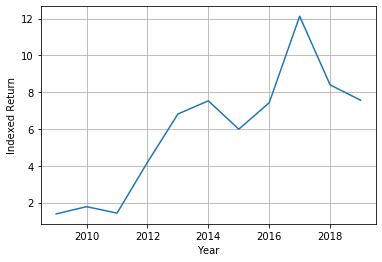

In [11]:
plt.plot(range(2009,2020),indx_rtns)
plt.grid()
plt.ylabel('Indexed Return')
plt.xlabel('Year')

In [13]:
# Return
indx_rtn

7.562505077668059

## Issues:
* No accounting for bankruptcy
* No accounting for mergers etc.